In [227]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
%matplotlib inline

import copy
import datetime
import traceback

import numpy as np

from base_vkr import read, get_files_conllu, build_vocabulary, pos_corpus_to_tensor
import pandas as pd

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import tqdm

In [228]:
url = '../../vkr/'
ramayana_files = get_files_conllu(f"{url}Rāmāyaṇa/")
hitopadesha_files = get_files_conllu(f"{url}Hitopadeśa/")
amarakosha_files = get_files_conllu(f"{url}Amarakośa/")
mahabharata_files = get_files_conllu(f"{url}Mahābhārata/")

In [229]:
train_files = ramayana_files + amarakosha_files#+ mahabharata_files
test_files = hitopadesha_files

train_df, train_sentences, train_all_tokens = read(train_files)
train_df.head()

,id,form,lemma,upos,xpos,feats,head,deprel,deps,misc
0,"(1, -, 2)",tatastasya,_,_,None,None,NaN,_,None,None
1,1,tatas,tatas,ADV,None,None,NaN,_,None,"{'LemmaId': '95922', 'OccId': '1263878', 'Unsa..."
2,2,tasya,tad,PRON,None,"{'Case': 'Gen', 'Gender': 'Masc', 'Number': 'S...",NaN,_,None,"{'LemmaId': '37875', 'OccId': '1263879', 'Unsa..."
3,3,gireḥ,giri,NOUN,None,"{'Case': 'Gen', 'Gender': 'Masc', 'Number': 'S...",NaN,_,None,"{'LemmaId': '123968', 'OccId': '1263880', 'Uns..."
4,4,śṛṅge,śṛṅga,NOUN,None,"{'Case': 'Loc', 'Gender': 'Neut', 'Number': 'S...",NaN,_,None,"{'LemmaId': '127269', 'OccId': '1263881', 'Uns..."


In [230]:
test_df, test_sentences, test_all_tokens = read(test_files)
test_df.head()

,id,form,lemma,upos,xpos,feats,head,deprel,deps,misc
0,1,atha,atha,ADV,None,None,None,_,None,"{'LemmaId': '7467', 'OccId': '630881', 'Unsand..."
1,"(2, -, 3)",prāsādapṛṣṭhe,_,_,None,None,None,_,None,None
2,2,prāsāda,prāsāda,NOUN,None,{'Case': 'Cpd'},None,_,None,"{'LemmaId': '152295', 'OccId': '630882', 'Unsa..."
3,3,pṛṣṭhe,pṛṣṭha,NOUN,None,"{'Case': 'Loc', 'Gender': 'Neut', 'Number': 'S...",None,_,None,"{'LemmaId': '150091', 'OccId': '630883', 'Unsa..."
4,"(4, -, 5)",sukhopaviṣṭānāṃ,_,_,None,None,None,_,None,None


In [231]:
len(train_sentences)

39893

In [232]:
train_df.shape

(320555, 10)

In [233]:
train_sentences_splited = [' '.join([s['form'] for s in sent if str(s['id']).isdigit()]) for sent in train_sentences]
train_sentences_splited[:5]

['tatas tasya gireḥ śṛṅge mahendrasya mahā balāḥ',
 'hanumat pramukhāḥ prītiṃ harayo jagmur uttamām',
 'taṃ tataḥ pratisaṃhṛṣṭaḥ prītimantaṃ mahā kapim',
 'jāmbavān kārya vṛttāntam apṛcchad anilātmajam',
 'kathaṃ dṛṣṭā tvayā devī kathaṃ vā tatra vartate']

In [234]:
test_sentences_splited = [' '.join([s['form'] for s in sent if str(s['id']).isdigit()]) for sent in test_sentences]
test_sentences_splited[:5]

["atha prāsāda pṛṣṭhe sukha upaviṣṭānām rāja putrāṇām purastāt prastāva krameṇa paṇḍito 'bravīt",
 'bho rāja putrāḥ śṛṇuta',
 'kāvya śāstra vinodena kālo gacchati dhīmatām',
 'vyasanena tu mūrkhāṇāṃ nidrayā kalahena vā',
 'tad bhavatāṃ vinodāya kāka kūrma ādīnām vicitrāṃ kathāṃ kathayiṣyāmi']

In [235]:
test_all_tokens[:5]

[{'id': 1,
  'form': 'atha',
  'lemma': 'atha',
  'upos': 'ADV',
  'xpos': None,
  'feats': None,
  'head': None,
  'deprel': '_',
  'deps': None,
  'misc': {'LemmaId': '7467',
   'OccId': '630881',
   'Unsandhied': 'atha',
   'UnsandhiedReconstructed': 'True'}},
 {'id': (2, '-', 3),
  'form': 'prāsādapṛṣṭhe',
  'lemma': '_',
  'upos': '_',
  'xpos': None,
  'feats': None,
  'head': None,
  'deprel': '_',
  'deps': None,
  'misc': None},
 {'id': 2,
  'form': 'prāsāda',
  'lemma': 'prāsāda',
  'upos': 'NOUN',
  'xpos': None,
  'feats': {'Case': 'Cpd'},
  'head': None,
  'deprel': '_',
  'deps': None,
  'misc': {'LemmaId': '152295',
   'OccId': '630882',
   'Unsandhied': 'prāsāda',
   'UnsandhiedReconstructed': 'True'}},
 {'id': 3,
  'form': 'pṛṣṭhe',
  'lemma': 'pṛṣṭha',
  'upos': 'NOUN',
  'xpos': None,
  'feats': {'Case': 'Loc', 'Gender': 'Neut', 'Number': 'Sing'},
  'head': None,
  'deprel': '_',
  'deps': None,
  'misc': {'LemmaId': '150091',
   'OccId': '630883',
   'Unsandhied': '

In [236]:
test_all_tokens_clean = [(token['form'], token['upos'], token['feats']) for token in test_all_tokens if str(token['id']).isdigit()]
test_all_tokens_clean[:5]

[('atha', 'ADV', None),
 ('prāsāda', 'NOUN', {'Case': 'Cpd'}),
 ('pṛṣṭhe', 'NOUN', {'Case': 'Loc', 'Gender': 'Neut', 'Number': 'Sing'}),
 ('sukha', 'NOUN', {'Case': 'Cpd'}),
 ('upaviṣṭānām',
  'VERB',
  {'Case': 'Gen', 'Gender': 'Masc', 'Number': 'Plur', 'VerbForm': 'Part'})]

In [237]:
train_all_tokens_clean = [(token['form'], token['upos'], token['feats']) for token in train_all_tokens if str(token['id']).isdigit()]
train_all_tokens_clean[:5]

[('tatas', 'ADV', None),
 ('tasya', 'PRON', {'Case': 'Gen', 'Gender': 'Masc', 'Number': 'Sing'}),
 ('gireḥ', 'NOUN', {'Case': 'Gen', 'Gender': 'Masc', 'Number': 'Sing'}),
 ('śṛṅge', 'NOUN', {'Case': 'Loc', 'Gender': 'Neut', 'Number': 'Sing'}),
 ('mahendrasya', 'NOUN', {'Case': 'Gen', 'Gender': 'Masc', 'Number': 'Sing'})]

In [238]:
train_df.loc[0].id

(1, '-', 2)

In [239]:
train_sents = range(len(train_sentences))
train_used_sents = []

def calc(row):
    if row.name == 0:
        train_used_sents.append(0)
        return train_sents[0]
    else:
        s = train_used_sents[len(train_used_sents) - 1]
        if row['id'] == 1 and row.name != 1:
            s += 1
            train_used_sents.append(s)
        return train_sents[s]

train_df['sent'] = train_df.apply(lambda row: calc(row), axis=1)
train_df[:30]

,id,form,lemma,upos,xpos,feats,head,deprel,deps,misc,sent
0,"(1, -, 2)",tatastasya,_,_,None,None,NaN,_,None,None,0
1,1,tatas,tatas,ADV,None,None,NaN,_,None,"{'LemmaId': '95922', 'OccId': '1263878', 'Unsa...",0
2,2,tasya,tad,PRON,None,"{'Case': 'Gen', 'Gender': 'Masc', 'Number': 'S...",NaN,_,None,"{'LemmaId': '37875', 'OccId': '1263879', 'Unsa...",0
3,3,gireḥ,giri,NOUN,None,"{'Case': 'Gen', 'Gender': 'Masc', 'Number': 'S...",NaN,_,None,"{'LemmaId': '123968', 'OccId': '1263880', 'Uns...",0
4,4,śṛṅge,śṛṅga,NOUN,None,"{'Case': 'Loc', 'Gender': 'Neut', 'Number': 'S...",NaN,_,None,"{'LemmaId': '127269', 'OccId': '1263881', 'Uns...",0
5,5,mahendrasya,mahendra,NOUN,None,"{'Case': 'Gen', 'Gender': 'Masc', 'Number': 'S...",NaN,_,None,"{'LemmaId': '77912', 'OccId': '1263882', 'Unsa...",0
6,"(6, -, 7)",mahābalāḥ,_,_,None,None,NaN,_,None,None,0
7,6,mahā,mahat,ADJ,None,{'Case': 'Cpd'},NaN,_,None,"{'LemmaId': '37544', 'OccId': '1263883', 'Unsa...",0
8,7,balāḥ,bala,NOUN,None,"{'Case': 'Nom', 'Gender': 'Masc', 'Number': 'P...",NaN,_,None,"{'LemmaId': '154315', 'OccId': '1263884', 'Uns...",0
9,"(1, -, 2)",hanumatpramukhāḥ,_,_,None,None,NaN,_,None,None,0


In [240]:
test_sents = range(len(test_sentences))
test_used_sents = []

def calc(row):
    if row.name == 0:
        test_used_sents.append(0)
        return test_sents[0]
    else:
        s = test_used_sents[len(test_used_sents) - 1]
        if row['id'] == 1 and row.name != 1:
            s += 1
            test_used_sents.append(s)
        return test_sents[s]

test_df['sent'] = test_df.apply(lambda row: calc(row), axis=1)
test_df[:30]

,id,form,lemma,upos,xpos,feats,head,deprel,deps,misc,sent
0,1,atha,atha,ADV,None,None,None,_,None,"{'LemmaId': '7467', 'OccId': '630881', 'Unsand...",0
1,"(2, -, 3)",prāsādapṛṣṭhe,_,_,None,None,None,_,None,None,0
2,2,prāsāda,prāsāda,NOUN,None,{'Case': 'Cpd'},None,_,None,"{'LemmaId': '152295', 'OccId': '630882', 'Unsa...",0
3,3,pṛṣṭhe,pṛṣṭha,NOUN,None,"{'Case': 'Loc', 'Gender': 'Neut', 'Number': 'S...",None,_,None,"{'LemmaId': '150091', 'OccId': '630883', 'Unsa...",0
4,"(4, -, 5)",sukhopaviṣṭānāṃ,_,_,None,None,None,_,None,None,0
5,4,sukha,sukha,NOUN,None,{'Case': 'Cpd'},None,_,None,"{'LemmaId': '106817', 'OccId': '630884', 'Unsa...",0
6,5,upaviṣṭānām,upaviś,VERB,None,"{'Case': 'Gen', 'Gender': 'Masc', 'Number': 'P...",None,_,None,"{'LemmaId': '160546', 'OccId': '630885', 'Unsa...",0
7,"(6, -, 7)",rājaputrāṇāṃ,_,_,None,None,None,_,None,None,0
8,6,rāja,rājan,NOUN,None,{'Case': 'Cpd'},None,_,None,"{'LemmaId': '70467', 'OccId': '630886', 'Unsan...",0
9,7,putrāṇām,putra,NOUN,None,"{'Case': 'Gen', 'Gender': 'Masc', 'Number': 'P...",None,_,None,"{'LemmaId': '144475', 'OccId': '630887', 'Unsa...",0


In [241]:
df_train_clean = train_df[train_df['upos'] != '_']
df_train_clean[:30]

,id,form,lemma,upos,xpos,feats,head,deprel,deps,misc,sent
1,1,tatas,tatas,ADV,None,None,NaN,_,None,"{'LemmaId': '95922', 'OccId': '1263878', 'Unsa...",0
2,2,tasya,tad,PRON,None,"{'Case': 'Gen', 'Gender': 'Masc', 'Number': 'S...",NaN,_,None,"{'LemmaId': '37875', 'OccId': '1263879', 'Unsa...",0
3,3,gireḥ,giri,NOUN,None,"{'Case': 'Gen', 'Gender': 'Masc', 'Number': 'S...",NaN,_,None,"{'LemmaId': '123968', 'OccId': '1263880', 'Uns...",0
4,4,śṛṅge,śṛṅga,NOUN,None,"{'Case': 'Loc', 'Gender': 'Neut', 'Number': 'S...",NaN,_,None,"{'LemmaId': '127269', 'OccId': '1263881', 'Uns...",0
5,5,mahendrasya,mahendra,NOUN,None,"{'Case': 'Gen', 'Gender': 'Masc', 'Number': 'S...",NaN,_,None,"{'LemmaId': '77912', 'OccId': '1263882', 'Unsa...",0
7,6,mahā,mahat,ADJ,None,{'Case': 'Cpd'},NaN,_,None,"{'LemmaId': '37544', 'OccId': '1263883', 'Unsa...",0
8,7,balāḥ,bala,NOUN,None,"{'Case': 'Nom', 'Gender': 'Masc', 'Number': 'P...",NaN,_,None,"{'LemmaId': '154315', 'OccId': '1263884', 'Uns...",0
10,1,hanumat,hanumant,NOUN,None,{'Case': 'Cpd'},NaN,_,None,"{'LemmaId': '120808', 'OccId': '1263885', 'Uns...",1
11,2,pramukhāḥ,pramukha,ADJ,None,"{'Case': 'Nom', 'Gender': 'Masc', 'Number': 'P...",NaN,_,None,"{'LemmaId': '155425', 'OccId': '1263886', 'Uns...",1
12,3,prītiṃ,prīti,NOUN,None,"{'Case': 'Acc', 'Gender': 'Fem', 'Number': 'Si...",NaN,_,None,"{'LemmaId': '153269', 'OccId': '1263887', 'Uns...",1


In [242]:
df_test_clean = test_df[test_df['upos'] != '_']
df_test_clean[:30]

,id,form,lemma,upos,xpos,feats,head,deprel,deps,misc,sent
0,1,atha,atha,ADV,None,None,None,_,None,"{'LemmaId': '7467', 'OccId': '630881', 'Unsand...",0
2,2,prāsāda,prāsāda,NOUN,None,{'Case': 'Cpd'},None,_,None,"{'LemmaId': '152295', 'OccId': '630882', 'Unsa...",0
3,3,pṛṣṭhe,pṛṣṭha,NOUN,None,"{'Case': 'Loc', 'Gender': 'Neut', 'Number': 'S...",None,_,None,"{'LemmaId': '150091', 'OccId': '630883', 'Unsa...",0
5,4,sukha,sukha,NOUN,None,{'Case': 'Cpd'},None,_,None,"{'LemmaId': '106817', 'OccId': '630884', 'Unsa...",0
6,5,upaviṣṭānām,upaviś,VERB,None,"{'Case': 'Gen', 'Gender': 'Masc', 'Number': 'P...",None,_,None,"{'LemmaId': '160546', 'OccId': '630885', 'Unsa...",0
8,6,rāja,rājan,NOUN,None,{'Case': 'Cpd'},None,_,None,"{'LemmaId': '70467', 'OccId': '630886', 'Unsan...",0
9,7,putrāṇām,putra,NOUN,None,"{'Case': 'Gen', 'Gender': 'Masc', 'Number': 'P...",None,_,None,"{'LemmaId': '144475', 'OccId': '630887', 'Unsa...",0
10,8,purastāt,purastāt,ADV,None,None,None,_,None,"{'LemmaId': '143801', 'OccId': '630888', 'Unsa...",0
12,9,prastāva,prastāva,NOUN,None,{'Case': 'Cpd'},None,_,None,"{'LemmaId': '155766', 'OccId': '630889', 'Unsa...",0
13,10,krameṇa,krama,NOUN,None,"{'Case': 'Ins', 'Gender': 'Masc', 'Number': 'S...",None,_,None,"{'LemmaId': '134091', 'OccId': '630890', 'Unsa...",0


In [243]:
MAX_SENT_LEN = max(len(sent) for sent in train_sentences_splited)
MAX_ORIG_TOKEN_LEN = max(len(token[0]) for token in train_all_tokens_clean)
print('Наибольшая длина предложения', MAX_SENT_LEN)
print('Наибольшая длина токена', MAX_ORIG_TOKEN_LEN)

Наибольшая длина предложения 148
Наибольшая длина токена 21


In [244]:
MAX_SENT_LEN_test = max(len(sent) for sent in test_sentences_splited)
MAX_ORIG_TOKEN_LEN_test = max(len(token[0]) for token in test_all_tokens_clean)
print('Наибольшая длина предложения on test', MAX_SENT_LEN_test)
print('Наибольшая длина токена on test', MAX_ORIG_TOKEN_LEN_test)

Наибольшая длина предложения on test 316
Наибольшая длина токена on test 25


In [245]:
UNIQUE_TAGS = ['<NOTAG>'] + sorted(df_train_clean['upos'].value_counts().index)
label2id = {label: i for i, label in enumerate(UNIQUE_TAGS)}
label2id

{'<NOTAG>': 0,
 'ADJ': 1,
 'ADP': 2,
 'ADV': 3,
 'CONJ': 4,
 'INTJ': 5,
 'NOUN': 6,
 'NUM': 7,
 'PART': 8,
 'PRON': 9,
 'SCONJ': 10,
 'VERB': 11}

In [246]:
UNIQUE_TAGS_test = ['<NOTAG>'] + sorted(df_test_clean['upos'].value_counts().index)
label2id_test = {label: i for i, label in enumerate(UNIQUE_TAGS_test)}
label2id_test

{'<NOTAG>': 0,
 'ADJ': 1,
 'ADP': 2,
 'ADV': 3,
 'CONJ': 4,
 'INTJ': 5,
 'NOUN': 6,
 'NUM': 7,
 'PART': 8,
 'PRON': 9,
 'SCONJ': 10,
 'VERB': 11}

In [247]:
train_char_tokenized = [list(sent) for sent in train_sentences_splited]
train_char_tokenized[:3]

[['t',
  'a',
  't',
  'a',
  's',
  ' ',
  't',
  'a',
  's',
  'y',
  'a',
  ' ',
  'g',
  'i',
  'r',
  'e',
  'ḥ',
  ' ',
  'ś',
  'ṛ',
  'ṅ',
  'g',
  'e',
  ' ',
  'm',
  'a',
  'h',
  'e',
  'n',
  'd',
  'r',
  'a',
  's',
  'y',
  'a',
  ' ',
  'm',
  'a',
  'h',
  'ā',
  ' ',
  'b',
  'a',
  'l',
  'ā',
  'ḥ'],
 ['h',
  'a',
  'n',
  'u',
  'm',
  'a',
  't',
  ' ',
  'p',
  'r',
  'a',
  'm',
  'u',
  'k',
  'h',
  'ā',
  'ḥ',
  ' ',
  'p',
  'r',
  'ī',
  't',
  'i',
  'ṃ',
  ' ',
  'h',
  'a',
  'r',
  'a',
  'y',
  'o',
  ' ',
  'j',
  'a',
  'g',
  'm',
  'u',
  'r',
  ' ',
  'u',
  't',
  't',
  'a',
  'm',
  'ā',
  'm'],
 ['t',
  'a',
  'ṃ',
  ' ',
  't',
  'a',
  't',
  'a',
  'ḥ',
  ' ',
  'p',
  'r',
  'a',
  't',
  'i',
  's',
  'a',
  'ṃ',
  'h',
  'ṛ',
  'ṣ',
  'ṭ',
  'a',
  'ḥ',
  ' ',
  'p',
  'r',
  'ī',
  't',
  'i',
  'm',
  'a',
  'n',
  't',
  'a',
  'ṃ',
  ' ',
  'm',
  'a',
  'h',
  'ā',
  ' ',
  'k',
  'a',
  'p',
  'i',
  'm']]

In [248]:
char_vocab, word_doc_freq = build_vocabulary(train_char_tokenized, max_doc_freq=1.0, min_count=5, pad_word='<PAD>')
print("Количество уникальных символов", len(char_vocab))
print(list(char_vocab.items())[:10])

Количество уникальных символов 39
[('<PAD>', 0), (' ', 1), ('a', 2), ('ā', 3), ('t', 4), ('r', 5), ('h', 6), ('i', 7), ('m', 8), ('v', 9)]


In [249]:
for row in df_train_clean[['sent', 'id', 'form', 'upos']][:10].values:
    print(row)

[0 1 'tatas' 'ADV']
[0 2 'tasya' 'PRON']
[0 3 'gireḥ' 'NOUN']
[0 4 'śṛṅge' 'NOUN']
[0 5 'mahendrasya' 'NOUN']
[0 6 'mahā' 'ADJ']
[0 7 'balāḥ' 'NOUN']
[1 1 'hanumat' 'NOUN']
[1 2 'pramukhāḥ' 'ADJ']
[1 3 'prītiṃ' 'NOUN']


In [250]:
df_train_clean['upos'].value_counts()

upos
NOUN     115308
VERB      51286
ADJ       31594
PRON      28920
PART      16551
ADV       16022
CONJ      10359
NUM        1858
SCONJ       955
ADP         224
INTJ         62
Name: count, dtype: int64

In [251]:
df_test_clean['upos'].value_counts()

upos
NOUN     9275
VERB     5182
PRON     2904
ADJ      2258
ADV      2134
PART     1861
CONJ      872
SCONJ     337
NUM       130
ADP        29
INTJ        9
Name: count, dtype: int64

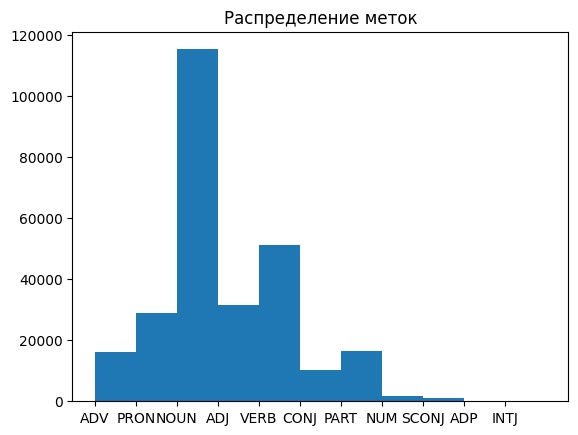

In [252]:
plt.hist(df_train_clean['upos'], bins=np.arange(0, 12))
plt.title('Распределение меток');

In [253]:
df_train_clean[['sent', 'id', 'form', 'upos']].head(10)

,sent,id,form,upos
1,0,1,tatas,ADV
2,0,2,tasya,PRON
3,0,3,gireḥ,NOUN
4,0,4,śṛṅge,NOUN
5,0,5,mahendrasya,NOUN
7,0,6,mahā,ADJ
8,0,7,balāḥ,NOUN
10,1,1,hanumat,NOUN
11,1,2,pramukhāḥ,ADJ
12,1,3,prītiṃ,NOUN


In [254]:
train_inputs, train_labels = pos_corpus_to_tensor(df_train_clean[['sent', 'id', 'form', 'upos']], char_vocab, label2id, MAX_SENT_LEN, MAX_ORIG_TOKEN_LEN)
train_dataset = TensorDataset(train_inputs, train_labels)

In [255]:
train_inputs[10][:5]

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0],
        [ 0, 11,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0],
        [ 0, 10,  7, 12, 13, 15,  4,  2, 17,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  4,  2,  4,  2, 11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  4, 18, 10,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0]])

In [256]:
train_labels[10]

tensor([ 0,  9, 11,  3,  9, 11,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0])

In [257]:
test_inputs, test_labels = pos_corpus_to_tensor(df_test_clean[['sent', 'id', 'form', 'upos']], char_vocab, label2id, MAX_SENT_LEN, MAX_ORIG_TOKEN_LEN)
test_dataset = TensorDataset(test_inputs, test_labels)

In [258]:
test_labels[10]

tensor([ 0, 11,  1,  6,  6,  6,  6,  6,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0])

In [259]:
class SingleTokenPOSTaggerLSTM(nn.Module):
    def __init__(self, vocab_size, labels_num, embedding_size=32, hidden_dim=128, layers_n=1, dropout=0.0):
        super().__init__()
        self.char_embeddings = nn.Embedding(vocab_size, embedding_size, padding_idx=0)
        self.backbone = nn.LSTM(embedding_size, hidden_dim, num_layers=layers_n, dropout=dropout if layers_n > 1 else 0)
        self.global_pooling = nn.AdaptiveMaxPool1d(1)
        self.out = nn.Linear(hidden_dim, labels_num)
        self.dropout = nn.Dropout(dropout)
        self.labels_num = labels_num
    
    def forward(self, tokens):
        """tokens - BatchSize x MaxSentenceLen x MaxTokenLen"""
        batch_size, max_sent_len, max_token_len = tokens.shape
        tokens_flat = tokens.view(batch_size * max_sent_len, max_token_len)
        
        char_embeddings = self.char_embeddings(tokens_flat)  # BatchSize*MaxSentenceLen x MaxTokenLen x EmbSize
        #char_embeddings = char_embeddings.permute(0, 2, 1)  # BatchSize*MaxSentenceLen x EmbSize x MaxTokenLen
        #print(char_embeddings.shape)
        features, _ = self.backbone(char_embeddings)
        #print(features.shape)

        features = features.permute(0, 2, 1)  # BatchSize*MaxSentenceLen x EmbSize x MaxTokenLen
        #print(features.shape)
        global_features = self.global_pooling(features).squeeze(-1)  # BatchSize*MaxSentenceLen x EmbSize
        #print(global_features.shape)
        logits_flat = self.out(global_features)  # BatchSize*MaxSentenceLen x LabelsNum
        #print(logits_flat.shape)
        logits = logits_flat.view(batch_size, max_sent_len, self.labels_num)  # BatchSize x MaxSentenceLen x LabelsNum
        #print(logits.shape)
        logits = logits.permute(0, 2, 1)  # BatchSize x LabelsNum x MaxSentenceLen
        #print(logits.shape)
        return logits

In [260]:
single_token_model = SingleTokenPOSTaggerLSTM(len(char_vocab), len(label2id), embedding_size=64, hidden_dim=64, layers_n=1, dropout=0.3)
print('Количество параметров', sum(np.prod(t.shape) for t in single_token_model.parameters()))

Количество параметров 36556


In [261]:
def get_device(device):
    if device is None:
        if torch.cuda.is_available():
            return torch.device("cuda")
        elif torch.backends.mps.is_available():
            return torch.device("mps")
        else:
            return torch.device("cpu")
    else:
        return torch.device(device)

def copy_data_to_device(data, device):
    if torch.is_tensor(data):
        return data.to(device)
    elif isinstance(data, (list, tuple)):
        return [copy_data_to_device(elem, device) for elem in data]
    raise ValueError('Недопустимый тип данных {}'.format(type(data)))

def train_eval_loop(model, train_dataset, val_dataset, criterion,
                    lr=1e-4, epoch_n=10, batch_size=32,
                    device=None, early_stopping_patience=10, l2_reg_alpha=0,
                    max_batches_per_epoch_train=10000,
                    max_batches_per_epoch_val=1000,
                    data_loader_ctor=DataLoader,
                    optimizer_ctor=None,
                    lr_scheduler_ctor=None,
                    shuffle_train=True,
                    dataloader_workers_n=0):
    """
    Цикл для обучения модели. После каждой эпохи качество модели оценивается по отложенной выборке.
    :param model: torch.nn.Module - обучаемая модель
    :param train_dataset: torch.utils.data.Dataset - данные для обучения
    :param val_dataset: torch.utils.data.Dataset - данные для оценки качества
    :param criterion: функция потерь для настройки модели
    :param lr: скорость обучения
    :param epoch_n: максимальное количество эпох
    :param batch_size: количество примеров, обрабатываемых моделью за одну итерацию
    :param device: mps/cuda/cpu - устройство, на котором выполнять вычисления
    :param early_stopping_patience: наибольшее количество эпох, в течение которых допускается
        отсутствие улучшения модели, чтобы обучение продолжалось.
    :param l2_reg_alpha: коэффициент L2-регуляризации
    :param max_batches_per_epoch_train: максимальное количество итераций на одну эпоху обучения
    :param max_batches_per_epoch_val: максимальное количество итераций на одну эпоху валидации
    :param data_loader_ctor: функция для создания объекта, преобразующего датасет в батчи
        (по умолчанию torch.utils.data.DataLoader)
    :return: кортеж из двух элементов:
        - среднее значение функции потерь на валидации на лучшей эпохе
        - лучшая модель
    """
    
    device = get_device(device)
    model.to(device)

    if optimizer_ctor is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_reg_alpha)
    else:
        optimizer = optimizer_ctor(model.parameters(), lr=lr)

    if lr_scheduler_ctor is not None:
        lr_scheduler = lr_scheduler_ctor(optimizer)
    else:
        lr_scheduler = None

    train_dataloader = data_loader_ctor(train_dataset, batch_size=batch_size, shuffle=shuffle_train,
                                        num_workers=dataloader_workers_n)
    val_dataloader = data_loader_ctor(val_dataset, batch_size=batch_size, shuffle=False,
                                      num_workers=dataloader_workers_n)

    best_val_loss = float('inf')
    best_epoch_i = 0
    best_model = copy.deepcopy(model)

    for epoch_i in range(epoch_n):
        try:
            epoch_start = datetime.datetime.now()
            print('Эпоха {}'.format(epoch_i))

            model.train()
            mean_train_loss = 0
            train_batches_n = 0
            for batch_i, (batch_x, batch_y) in enumerate(train_dataloader):
                if batch_i > max_batches_per_epoch_train:
                    break

                batch_x = copy_data_to_device(batch_x, device)
                batch_y = copy_data_to_device(batch_y, device)

                pred = model(batch_x)
                loss = criterion(pred, batch_y)

                model.zero_grad()
                loss.backward()

                optimizer.step()

                mean_train_loss += float(loss)
                train_batches_n += 1

            mean_train_loss /= train_batches_n
            print('Эпоха: {} итераций, {:0.2f} сек'.format(train_batches_n,
                                                           (datetime.datetime.now() - epoch_start).total_seconds()))
            print('Среднее значение функции потерь на обучении', mean_train_loss)



            model.eval()
            mean_val_loss = 0
            val_batches_n = 0

            with torch.no_grad():
                for batch_i, (batch_x, batch_y) in enumerate(val_dataloader):
                    if batch_i > max_batches_per_epoch_val:
                        break

                    batch_x = copy_data_to_device(batch_x, device)
                    batch_y = copy_data_to_device(batch_y, device)

                    pred = model(batch_x)
                    loss = criterion(pred, batch_y)

                    mean_val_loss += float(loss)
                    val_batches_n += 1

            mean_val_loss /= val_batches_n
            print('Среднее значение функции потерь на валидации', mean_val_loss)

            if mean_val_loss < best_val_loss:
                best_epoch_i = epoch_i
                best_val_loss = mean_val_loss
                best_model = copy.deepcopy(model)
                print('Новая лучшая модель!')
            elif epoch_i - best_epoch_i > early_stopping_patience:
                print('Модель не улучшилась за последние {} эпох, прекращаем обучение'.format(
                    early_stopping_patience))
                break

            if lr_scheduler is not None:
                lr_scheduler.step(mean_val_loss)

            print()
        except KeyboardInterrupt:
            print('Досрочно остановлено пользователем')
            break
        except Exception as ex:
            print('Ошибка при обучении: {}\n{}'.format(ex, traceback.format_exc()))
            break

    return best_val_loss, best_model

In [262]:
(best_val_loss,
 best_single_token_model) = train_eval_loop(single_token_model,
                                            train_dataset,
                                            test_dataset,
                                            F.cross_entropy,
                                            lr=5e-3,
                                            epoch_n=10,
                                            batch_size=64,
                                            early_stopping_patience=5,
                                            max_batches_per_epoch_train=500,
                                            max_batches_per_epoch_val=100,
                                            lr_scheduler_ctor=lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=2,
                                                                                                                       factor=0.5)) #,verbose=True

Эпоха 0
Эпоха: 501 итераций, 645.90 сек
Среднее значение функции потерь на обучении 0.0952455754393708
Среднее значение функции потерь на валидации 0.05646708945709246
Новая лучшая модель!

Эпоха 1
Эпоха: 501 итераций, 701.66 сек
Среднее значение функции потерь на обучении 0.043505021250117085
Среднее значение функции потерь на валидации 0.05063313018116686
Новая лучшая модель!

Эпоха 2
Эпоха: 501 итераций, 647.76 сек
Среднее значение функции потерь на обучении 0.04002656380900604
Среднее значение функции потерь на валидации 0.04851716556758792
Новая лучшая модель!

Эпоха 3
Эпоха: 501 итераций, 616.87 сек
Среднее значение функции потерь на обучении 0.03798783398019578
Среднее значение функции потерь на валидации 0.047480512134454866
Новая лучшая модель!

Эпоха 4
Эпоха: 501 итераций, 615.81 сек
Среднее значение функции потерь на обучении 0.036413302195226836
Среднее значение функции потерь на валидации 0.04581948769865213
Новая лучшая модель!

Эпоха 5
Эпоха: 501 итераций, 633.45 сек
Сре

In [272]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./
torch.save(best_single_token_model.state_dict(), './single_token_pos_lstm.pth')

In [273]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./
single_token_model.load_state_dict(torch.load('./single_token_pos_lstm.pth'))

<All keys matched successfully>

In [274]:
def predict_with_model(model, dataset, device=None, batch_size=64, num_workers=0, return_labels=False):
    """
    :param model: torch.nn.Module - обученная модель
    :param dataset: torch.utils.data.Dataset - данные для применения модели
    :param device: mps/cuda/cpu - устройство, на котором выполнять вычисления
    :param batch_size: количество примеров, обрабатываемых моделью за одну итерацию
    :return: numpy.array размерности len(dataset) x *
    """
    device = get_device(device)
    results_by_batch = []

    model.to(device)
    model.eval()

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    labels = []
    with torch.no_grad():
        for batch_x, batch_y in tqdm.tqdm(dataloader, total=len(dataset)/batch_size):
            batch_x = copy_data_to_device(batch_x, device)

            if return_labels:
                labels.append(batch_y.numpy())

            batch_pred = model(batch_x)
            results_by_batch.append(batch_pred.detach().cpu().numpy())

    if return_labels:
        return np.concatenate(results_by_batch, 0), np.concatenate(labels, 0)
    else:
        return np.concatenate(results_by_batch, 0)

In [280]:
train_pred = predict_with_model(single_token_model, train_dataset)
train_loss = F.cross_entropy(torch.tensor(train_pred),
                             torch.tensor(train_labels))
print('Среднее значение функции потерь на обучении', float(train_loss))
print(classification_report(train_labels.reshape(-1), train_pred.argmax(1).reshape(-1), target_names=UNIQUE_TAGS))

print()

test_pred = predict_with_model(single_token_model, test_dataset)
test_loss = F.cross_entropy(torch.tensor(test_pred),
                            torch.tensor(test_labels))
print('Среднее значение функции потерь на валидации', float(test_loss))
print(classification_report(test_labels.reshape(-1), test_pred.argmax(1).reshape(-1), target_names=UNIQUE_TAGS))

624it [02:03,  5.04it/s]                                


Среднее значение функции потерь на обучении 0.03114091418683529
              precision    recall  f1-score   support

     <NOTAG>       1.00      1.00      1.00   5631025
         ADJ       0.63      0.28      0.39     31594
         ADP       0.77      0.35      0.48       224
         ADV       0.80      0.65      0.72     16022
        CONJ       0.99      0.99      0.99     10359
        INTJ       0.00      0.00      0.00        62
        NOUN       0.71      0.88      0.79    115308
         NUM       0.84      0.21      0.34      1858
        PART       0.98      0.97      0.98     16551
        PRON       0.87      0.87      0.87     28920
       SCONJ       0.64      0.64      0.64       955
        VERB       0.69      0.61      0.65     51286

    accuracy                           0.99   5904164
   macro avg       0.74      0.62      0.65   5904164
weighted avg       0.99      0.99      0.99   5904164




101%|██████████| 54/53.625 [00:11<00:00,  4.90it/s]

Среднее значение функции потерь на валидации 0.04175055772066116
              precision    recall  f1-score   support

     <NOTAG>       1.00      1.00      1.00    482945
         ADJ       0.38      0.16      0.22      2258
         ADP       0.83      0.69      0.75        29
         ADV       0.78      0.56      0.65      2134
        CONJ       0.98      0.98      0.98       872
        INTJ       0.00      0.00      0.00         9
        NOUN       0.66      0.84      0.74      9275
         NUM       0.64      0.21      0.31       130
        PART       0.95      0.94      0.95      1861
        PRON       0.79      0.82      0.80      2904
       SCONJ       0.71      0.27      0.39       337
        VERB       0.64      0.60      0.62      5182

    accuracy                           0.99    507936
   macro avg       0.70      0.59      0.62    507936
weighted avg       0.98      0.99      0.98    507936



In [275]:
class POSTagger:
    def __init__(self, model, char2id, id2label, max_sent_len, max_token_len):
        self.model = model
        self.char2id = char2id
        self.id2label = id2label
        self.max_sent_len = max_sent_len
        self.max_token_len = max_token_len

    def __call__(self, sentences):
        tokenized_corpus = [sent.split() for sent in sentences]

        inputs = torch.zeros((len(sentences), self.max_sent_len, self.max_token_len + 2), dtype=torch.long)

        for sent_i, sentence in enumerate(tokenized_corpus):
            for token_i, token in enumerate(sentence):
                for char_i, char in enumerate(token):
                    inputs[sent_i, token_i, char_i + 1] = self.char2id.get(char, 0)

        dataset = TensorDataset(inputs, torch.zeros(len(sentences)))
        predicted_probs = predict_with_model(self.model, dataset)  # SentenceN x TagsN x MaxSentLen
        predicted_classes = predicted_probs.argmax(1)

        result = []
        for sent_i, sent in enumerate(tokenized_corpus):
            result.append([self.id2label[cls] for cls in predicted_classes[sent_i, :len(sent)]])
        return result

In [276]:
single_token_pos_tagger = POSTagger(single_token_model, char_vocab, UNIQUE_TAGS, MAX_SENT_LEN, MAX_ORIG_TOKEN_LEN)

In [277]:
test_sentences = [
    'atha kanyā pradāne sa tam eva arthaṁ vicintayan',
    'samāninye ca tat sarvaṁ bhāṇḍaṁ vaivāhikaṁ nṛpaḥ',
    'śrutvā vas tu samagraṃ tad dharma ātmā dharma saṃhitam',
    'sveditaḥ marditaḥ ca eva rañjubhiḥ pariveṣṭitaḥ',
    'ete vo gaṇitā vāsā yatra yatra nivatsyatha',
    'kiṃ kāryaṃ brūta bhavatāṃ bhayaṃ nāśayitāsmi vaḥ',
]
test_sentences_tokenized = [sent.split() for sent in test_sentences]

In [278]:
test_sentences_tokenized

[['atha', 'kanyā', 'pradāne', 'sa', 'tam', 'eva', 'arthaṁ', 'vicintayan'],
 ['samāninye', 'ca', 'tat', 'sarvaṁ', 'bhāṇḍaṁ', 'vaivāhikaṁ', 'nṛpaḥ'],
 ['śrutvā',
  'vas',
  'tu',
  'samagraṃ',
  'tad',
  'dharma',
  'ātmā',
  'dharma',
  'saṃhitam'],
 ['sveditaḥ', 'marditaḥ', 'ca', 'eva', 'rañjubhiḥ', 'pariveṣṭitaḥ'],
 ['ete', 'vo', 'gaṇitā', 'vāsā', 'yatra', 'yatra', 'nivatsyatha'],
 ['kiṃ', 'kāryaṃ', 'brūta', 'bhavatāṃ', 'bhayaṃ', 'nāśayitāsmi', 'vaḥ']]

In [279]:
for sent_tokens, sent_tags in zip(test_sentences_tokenized, single_token_pos_tagger(test_sentences)):
    print(' '.join('{}-{}'.format(tok, tag) for tok, tag in zip(sent_tokens, sent_tags)))
    print()

1it [00:00,  1.31it/s]                     

atha-ADV kanyā-NOUN pradāne-NOUN sa-PRON tam-PRON eva-PART arthaṁ-NOUN vicintayan-VERB

samāninye-VERB ca-CONJ tat-PRON sarvaṁ-PRON bhāṇḍaṁ-NOUN vaivāhikaṁ-NOUN nṛpaḥ-NOUN

śrutvā-VERB vas-ADJ tu-PART samagraṃ-NOUN tad-PRON dharma-NOUN ātmā-NOUN dharma-NOUN saṃhitam-VERB

sveditaḥ-VERB marditaḥ-NOUN ca-CONJ eva-PART rañjubhiḥ-NOUN pariveṣṭitaḥ-VERB

ete-PRON vo-NOUN gaṇitā-VERB vāsā-NOUN yatra-SCONJ yatra-SCONJ nivatsyatha-VERB

kiṃ-PRON kāryaṃ-NOUN brūta-NOUN bhavatāṃ-VERB bhayaṃ-NOUN nāśayitāsmi-VERB vaḥ-NOUN

